<a href="https://colab.research.google.com/github/ovoma-commits/Team12_STA160/blob/main/STA_160_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
u = files.upload()
fname = next(iter(u))
import pandas as pd
airbnb = pd.read_csv(fname, sep=None, engine='python')

Saving airbnbvars.csv to airbnbvars.csv


In [ ]:
cities = [
    'Los Angeles', 'Oakland', 'Pacific Grove',
    'San Diego', 'San Francisco', 'San Mateo',
    'Santa Clara', 'Santa Cruz'
]

In [ ]:
from sklearn.model_selection import train_test_split
for city in cities:
    city_data = airbnb[airbnb['city'] == city]

    X_train, X_test = train_test_split(
        city_data,
        test_size=0.2,
        random_state=42
    )

    train_varname = f"{city.replace(' ', '')}_train"
    test_varname = f"{city.replace(' ', '')}_test"

    globals()[train_varname] = X_train.reset_index(drop=True)
    globals()[test_varname] = X_test.reset_index(drop=True)

print(f"{'City':<15} {'Train Var':<25} {'Train Rows':<10} {'Test Var':<25} {'Test Rows':<10}")
print("-" * 90)

for city in cities:
    train_varname = f"{city.replace(' ', '')}_train"
    test_varname = f"{city.replace(' ', '')}_test"

    train_rows = globals()[train_varname].shape[0]
    test_rows = globals()[test_varname].shape[0]

    print(f"{city:<15} {train_varname:<25} {train_rows:<10} {test_varname:<25} {test_rows:<10}")

City            Train Var                 Train Rows Test Var                  Test Rows 
------------------------------------------------------------------------------------------
Los Angeles     LosAngeles_train          29455      LosAngeles_test           7364      
Oakland         Oakland_train             1608       Oakland_test              403       
Pacific Grove   PacificGrove_train        220        PacificGrove_test         55        
San Diego       SanDiego_train            9283       SanDiego_test             2321      
San Francisco   SanFrancisco_train        4636       SanFrancisco_test         1159      
San Mateo       SanMateo_train            2361       SanMateo_test             591       
Santa Clara     SantaClara_train          4484       SantaClara_test           1121      
Santa Cruz      SantaCruz_train           1243       SantaCruz_test            311       


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

cities = ["Los Angeles","Oakland","Pacific Grove","San Diego",
          "San Francisco","San Mateo","Santa Clara","Santa Cruz"]

def varnames(city_label: str):
    no_space = city_label.replace(' ', '')
    return f"{no_space}_train", f"{no_space}_test"

numeric_sets = []
for city in cities:
    tr, _ = varnames(city)
    if tr not in globals():
        print(f"Skip {city}: {tr} not found")
        continue
    df = globals()[tr]
    num_cols = set(df.select_dtypes(include=[np.number]).columns) - {'price'}
    if num_cols:
        numeric_sets.append(num_cols)

if not numeric_sets:
    raise RuntimeError("No numeric feature sets found. Check your train splits.")

common_feats = sorted(set.intersection(*numeric_sets))
print(f"Using {len(common_feats)} common numeric features across all cities.")

rf_params = dict(
    n_estimators=400,
    max_depth=None,
    max_features='sqrt',
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

summary_rows = []
feature_tables = {}

for city in cities:
    tr, te = varnames(city)
    if tr not in globals() or te not in globals():
        print(f"Skipping {city}: {tr}/{te} not found")
        continue

    train_df = globals()[tr].copy()
    test_df  = globals()[te].copy()

    for d in (train_df, test_df):
        d['price'] = pd.to_numeric(d['price'], errors='coerce')
    train_df = train_df.dropna(subset=['price'])
    test_df  = test_df.dropna(subset=['price'])

    X_train = train_df.reindex(columns=common_feats).apply(pd.to_numeric, errors='coerce').fillna(0)
    X_test  = test_df.reindex(columns=common_feats).apply(pd.to_numeric, errors='coerce').fillna(0)
    y_train = train_df['price'].values
    y_test  = test_df['price'].values

    if X_train.shape[0] == 0 or X_train.shape[1] == 0:
        print(f"Skipping {city}: no valid rows/features after alignment")
        continue

    model = RandomForestRegressor(**rf_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
    r2   = r2_score(y_test, y_pred)

    importances = pd.Series(model.feature_importances_, index=common_feats).sort_values(ascending=False)
    feature_tables[city] = importances.to_frame(name='importance')

    topk = ", ".join(importances.head(3).index.tolist())
    print(f"{city:15s} | RMSE={rmse:8.2f} | R2={r2:6.4f} | top: {topk}")

    summary_rows.append({
        'City': city,
        'RMSE': rmse,
        'R2': r2,
        'n_train': X_train.shape[0],
        'n_test': X_test.shape[0],
        'n_feats': X_train.shape[1]
    })

summary_df = pd.DataFrame(summary_rows).sort_values('R2', ascending=False).reset_index(drop=True)
print("\n=== Summary ===")
print(summary_df)

Using 29 common numeric features across all cities.
Los Angeles     | RMSE= 1367.79 | R2=0.4036 | top: bathrooms, beds, review_scores_location
Oakland         | RMSE= 1984.01 | R2=0.5003 | top: review_scores_location, air conditioning, dryer
Pacific Grove   | RMSE=  166.47 | R2=0.1671 | top: bathrooms, bedrooms, beds
San Diego       | RMSE= 2722.48 | R2=0.6937 | top: hot water, heating, review_scores_location
San Francisco   | RMSE= 1155.75 | R2=0.4011 | top: review_scores_location, beds, hot water
San Mateo       | RMSE= 1893.00 | R2=0.7150 | top: beds, parking, review_scores_location
Santa Clara     | RMSE= 2749.10 | R2=0.4346 | top: bathrooms, review_scores_location, hot water
Santa Cruz      | RMSE= 3327.52 | R2=0.3021 | top: review_scores_location, air conditioning, refrigerator

=== Summary ===
            City         RMSE        R2  n_train  n_test  n_feats
0      San Mateo  1893.000907  0.714971     2361     591       29
1      San Diego  2722.478818  0.693735     9283    2321

In [ ]:
import numpy as np, pandas as pd

def prep_city(df):
    df = df.drop(columns=['neighborhood','room_type','city'], errors='ignore').copy()

    if 'price' in df.columns:
        lo, hi = np.nanpercentile(df['price'], [1, 99])
        df = df[(df['price'] >= lo) & (df['price'] <= hi)]

    if 'beds' in df.columns and 'bedrooms' in df.columns:
        df['beds_per_bedroom'] = df['beds'] / df['bedrooms'].replace(0, np.nan)
    if 'bathrooms' in df.columns and 'bedrooms' in df.columns:
        df['baths_per_bedroom'] = df['bathrooms'] / df['bedrooms'].replace(0, np.nan)

    num = df.select_dtypes(include=[np.number]).columns
    df[num] = df[num].fillna(0)
    return df

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

def fit_rf_oob(X_train, y_train_log, random_state=42):
    cands = [
        {"max_features": "sqrt", "min_samples_leaf": 1, "min_samples_split": 2},
        {"max_features": "sqrt", "min_samples_leaf": 2, "min_samples_split": 4},
        {"max_features": 0.5,    "min_samples_leaf": 2, "min_samples_split": 4},
        {"max_features": "log2", "min_samples_leaf": 2, "min_samples_split": 4},
    ]
    best, best_oob = None, -np.inf
    for p in cands:
        rf = RandomForestRegressor(
            n_estimators=500,
            bootstrap=True, oob_score=True,
            random_state=random_state, n_jobs=-1, **p
        )
        rf.fit(X_train, y_train_log)
        if rf.oob_score_ > best_oob:
            best, best_oob = rf, rf.oob_score_
    return best

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

def varnames(city_label: str):
    base = city_label.replace(' ', '').replace('_', '')
    return f'{base}_train', f'{base}_test'

def safe_perm_importance(model, X, y_log, feat_names, *,
                         max_rows=1000, n_repeats=3, n_jobs=1, random_state=42, topk=5):
    if X.shape[0] > max_rows:
        rs = np.random.RandomState(random_state)
        idx = rs.choice(X.shape[0], size=max_rows, replace=False)
        X_sub = X.iloc[idx]
        y_sub = y_log[idx]
    else:
        X_sub, y_sub = X, y_log

    try:
        pi = permutation_importance(
            model, X_sub, y_sub,
            n_repeats=n_repeats, random_state=random_state, n_jobs=n_jobs
        )
        order = np.argsort(-pi.importances_mean)[:topk]
        return [feat_names[i] for i in order]
    except Exception:
        if hasattr(model, "feature_importances_"):
            imp = pd.Series(model.feature_importances_, index=feat_names).sort_values(ascending=False)
            return imp.head(topk).index.tolist()
        return feat_names[:topk]

cities = [
    'Los Angeles', 'Oakland', 'Pacific Grove', 'San Diego',
    'San Francisco', 'San Mateo', 'Santa Clara', 'Santa Cruz'
]

rf_params = dict(
    n_estimators=500,
    max_depth=None,
    max_features='sqrt',
    min_samples_split=4,
    min_samples_leaf=2,
    bootstrap=True,
    oob_score=False,
    random_state=42,
    n_jobs=2
)

results = []
models  = {}
tops    = {}

print("Using RandomForestRegressor with log-target training; metrics reported on original scale.\n")

for city in cities:
    tr_name, te_name = varnames(city)

    if tr_name not in globals() or te_name not in globals():
        print(f"Skipping {city}: {tr_name}/{te_name} not found")
        continue

    train_df = globals()[tr_name].copy()
    test_df  = globals()[te_name].copy()

    if 'price' not in train_df.columns or 'price' not in test_df.columns:
        print(f"Skipping {city}: 'price' column missing")
        continue

    feat_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
    if 'price' in feat_cols:
        feat_cols.remove('price')

    X_tr = train_df[feat_cols].apply(pd.to_numeric, errors='coerce').fillna(0)
    y_tr = train_df['price'].values

    X_te = test_df.reindex(columns=feat_cols).apply(pd.to_numeric, errors='coerce').fillna(0)
    y_te = test_df['price'].values

    if X_tr.shape[0] == 0 or X_tr.shape[1] == 0:
        print(f"Skipping {city}: no valid rows/features after cleaning")
        continue

    model = RandomForestRegressor(**rf_params)
    model.fit(X_tr, np.log1p(y_tr))

    y_pred = np.expm1(model.predict(X_te))

    rmse = float(np.sqrt(mean_squared_error(y_te, y_pred)))
    r2   = r2_score(y_te, y_pred)

    top_feats = safe_perm_importance(
        model, X_te, np.log1p(y_te), feat_cols,
        max_rows=1000, n_repeats=3, n_jobs=1, random_state=42, topk=5
    )

    models[city] = model
    tops[city]   = top_feats
    results.append({
        'City': city,
        'RMSE': rmse,
        'R2': r2,
        'n_train': X_tr.shape[0],
        'n_test': X_te.shape[0],
        'n_feats': len(feat_cols),
        'Top_Features': ', '.join(top_feats)
    })

    print(f"{city:15s} | RMSE={rmse:8.2f} | R2={r2:6.4f} | feats={len(feat_cols):2d} | top: {', '.join(top_feats)}")

summary_df = pd.DataFrame(results).sort_values('R2', ascending=False).reset_index(drop=True)
print("\n=== Summary ===")
print(summary_df[['City','RMSE','R2','n_train','n_test','n_feats','Top_Features']])

Using RandomForestRegressor with log-target training; metrics reported on original scale.

Los Angeles     | RMSE= 1702.98 | R2=0.0755 | feats=29 | top: bedrooms, bathrooms, shared_bathroom, beds, review_scores_location
Oakland         | RMSE= 2780.75 | R2=0.0183 | feats=29 | top: bedrooms, shared_bathroom, parking, dryer, bathrooms
Pacific Grove   | RMSE=  161.29 | R2=0.2182 | feats=29 | top: refrigerator, bathrooms, review_scores_location, bedrooms, oven
San Diego       | RMSE= 4608.34 | R2=0.1225 | feats=29 | top: hot water, bedrooms, parking, review_scores_location, air conditioning
San Francisco   | RMSE= 1455.13 | R2=0.0507 | feats=29 | top: shared_bathroom, bedrooms, bathrooms, air conditioning, review_scores_location
San Mateo       | RMSE= 2686.13 | R2=0.4261 | feats=29 | top: bedrooms, beds, review_scores_location, shared_bathroom, hot water
Santa Clara     | RMSE= 3400.56 | R2=0.1349 | feats=29 | top: shared_bathroom, bedrooms, review_scores_location, hot water, bathrooms
Sa

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

def winsorize_series_train_test(y_train, y_test, lower=0.0, upper=0.99):
    lo = np.quantile(y_train, lower)
    hi = np.quantile(y_train, upper)
    y_tr = np.clip(y_train, lo, hi)
    y_te = np.clip(y_test,  lo, hi)
    return y_tr, y_te

def add_simple_feats(df):
    out = df.copy()
    eps = 1e-6
    for col in ['bedrooms','bathrooms','beds']:
        if col not in out: out[col] = 0.0
    out['beds_per_bedroom']  = out['beds']/(out['bedrooms']+eps)
    out['bath_per_bedroom']  = out['bathrooms']/(out['bedrooms']+eps)
    out['capacity_proxy']    = out['bedrooms'] + 0.5*out['bathrooms']
    return out

rf_big = dict(n_estimators=800, max_depth=22, max_features=0.5,
              min_samples_split=6, min_samples_leaf=3, bootstrap=True,
              random_state=42, n_jobs=2)
rf_small = dict(n_estimators=500, max_depth=14, max_features='sqrt',
                min_samples_split=4, min_samples_leaf=2, bootstrap=True,
                random_state=42, n_jobs=2)

results = []
models  = {}
tops    = {}

print("RF + winsorize + simple features; report raw & log-scale metrics.\n")

for city in ['Los Angeles','Oakland','Pacific Grove','San Diego',
             'San Francisco','San Mateo','Santa Clara','Santa Cruz']:
    tr_name, te_name = varnames(city)
    if tr_name not in globals() or te_name not in globals():
        print(f"Skipping {city}: {tr_name}/{te_name} not found")
        continue

    tr = globals()[tr_name].copy()
    te = globals()[te_name].copy()

    if 'price' not in tr or 'price' not in te:
        print(f"Skipping {city}: 'price' missing")
        continue

    feat_cols = tr.select_dtypes(include=[np.number]).columns.tolist()
    feat_cols = [c for c in feat_cols if c!='price']
    trX = add_simple_feats(tr[feat_cols]).apply(pd.to_numeric, errors='coerce').fillna(0)
    teX = add_simple_feats(te.reindex(columns=feat_cols)).apply(pd.to_numeric, errors='coerce').fillna(0)
    y_tr_raw = tr['price'].values
    y_te_raw = te['price'].values

    if trX.shape[0]==0 or trX.shape[1]==0:
        print(f"Skipping {city}: no valid data")
        continue

    y_tr_clip, y_te_clip = winsorize_series_train_test(y_tr_raw, y_te_raw, upper=0.99)

    params = rf_big if trX.shape[0] >= 4000 else rf_small
    model = RandomForestRegressor(**params)

    model.fit(trX, np.log1p(y_tr_clip))

    y_pred = np.expm1(model.predict(teX))

    rmse = float(np.sqrt(mean_squared_error(y_te_clip, y_pred)))
    r2   = r2_score(y_te_clip, y_pred)

    y_te_log   = np.log1p(y_te_clip)
    y_pred_log = np.log1p(np.maximum(y_pred, 0))
    rmsle = float(np.sqrt(mean_squared_error(y_te_log, y_pred_log)))
    r2log = r2_score(y_te_log, y_pred_log)

    imp = pd.Series(model.feature_importances_, index=trX.columns).sort_values(ascending=False)
    top_feats = imp.head(5).index.tolist()

    models[city] = model
    tops[city]   = top_feats
    results.append({
        'City': city, 'RMSE': rmse, 'R2': r2,
        'RMSLE': rmsle, 'R2_log': r2log,
        'n_train': trX.shape[0], 'n_test': teX.shape[0],
        'n_feats': trX.shape[1], 'Top_Features': ', '.join(top_feats)
    })

    print(f"{city:15s} | RMSE={rmse:8.2f} | R2={r2:6.4f} | RMSLE={rmsle:6.4f} | R2_log={r2log:6.4f} | top: {', '.join(top_feats)}")

summary = pd.DataFrame(results).sort_values('R2_log', ascending=False).reset_index(drop=True)
print("\n=== Summary ===")
print(summary[['City','RMSE','R2','RMSLE','R2_log','n_train','n_test','n_feats','Top_Features']])

RF + winsorize + simple features; report raw & log-scale metrics.

Los Angeles     | RMSE=  245.01 | R2=0.5764 | RMSLE=0.4925 | R2_log=0.6765 | top: capacity_proxy, bedrooms, bathrooms, shared_bathroom, review_scores_location
Oakland         | RMSE=   94.94 | R2=0.4553 | RMSLE=0.3910 | R2_log=0.5992 | top: capacity_proxy, bedrooms, beds, shared_bathroom, bathrooms
Pacific Grove   | RMSE=  161.52 | R2=0.2160 | RMSLE=0.4373 | R2_log=0.2500 | top: capacity_proxy, bathrooms, review_scores_location, bedrooms, beds
San Diego       | RMSE=  381.25 | R2=0.4402 | RMSLE=0.4809 | R2_log=0.6657 | top: capacity_proxy, bedrooms, beds, bathrooms, review_scores_location
San Francisco   | RMSE=  170.00 | R2=0.5268 | RMSLE=0.4426 | R2_log=0.6429 | top: shared_bathroom, bedrooms, capacity_proxy, review_scores_location, air conditioning
San Mateo       | RMSE= 2689.88 | R2=0.4245 | RMSLE=0.5038 | R2_log=0.6500 | top: beds, capacity_proxy, bedrooms, beds_per_bedroom, shared_bathroom
Santa Clara     | RMSE=

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

def add_more_feats(df):
    out = df.copy()
    eps = 1e-6

    for col in ['bedrooms', 'bathrooms', 'beds']:
        if col not in out:
            out[col] = 0.0

    out['beds_per_bedroom'] = out['beds'] / (out['bedrooms'] + eps)

    out['bath_per_bedroom'] = out['bathrooms'] / (out['bedrooms'] + eps)

    out['capacity_proxy'] = out['bedrooms'] + 0.5 * out['bathrooms']

    out['rooms_interact'] = out['bedrooms'] * out['bathrooms']

    out['bed_ratio'] = np.clip(out['beds_per_bedroom'], 0, 4)

    return out

def pick_rf_params(n_train):
    grids = [
        dict(max_features='sqrt', max_depth=14),
        dict(max_features='sqrt', max_depth=20),
        dict(max_features=0.5,   max_depth=14),
        dict(max_features=0.5,   max_depth=22),
    ]
    base = dict(n_estimators=600, min_samples_split=4, min_samples_leaf=2,
                bootstrap=True, oob_score=True, random_state=42, n_jobs=2)
    if n_train >= 8000:
        grids.append(dict(max_features=0.5, max_depth=None))
    return base, grids

def rmsle_on_raw(y_true, y_pred):
    y_true = np.asarray(y_true).clip(min=0)
    y_pred = np.asarray(y_pred).clip(min=0)
    return float(np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred))))

results = []

print("RF with OOB light tuning + 2 new features + relative metric (nRMSE)\n")

for city in ['Los Angeles','Oakland','Pacific Grove','San Diego',
             'San Francisco','San Mateo','Santa Clara','Santa Cruz']:

    tr_name, te_name = varnames(city)
    if tr_name not in globals() or te_name not in globals():
        print(f"Skipping {city}: {tr_name}/{te_name} not found")
        continue

    tr = globals()[tr_name].copy()
    te = globals()[te_name].copy()

    cols_to_drop = [
        'neighborhood', 'room_type', 'city',
        'review_scores_accuracy',
        'review_scores_cleanliness',
        'review_scores_communication',
        'review_scores_checkin',
        'review_scores_value'
    ]

    cols_to_drop += [c for c in tr.columns if 'Enroll' in c]

    tr.drop(columns=cols_to_drop, inplace=True, errors='ignore')
    te.drop(columns=cols_to_drop, inplace=True, errors='ignore')

    if 'price' not in tr or 'price' not in te:
        print(f"Skipping {city}: 'price' missing")
        continue

    feat_cols = tr.select_dtypes(include=[np.number]).columns.tolist()
    feat_cols = [c for c in feat_cols if c != 'price']
    X_tr = add_more_feats(tr[feat_cols]).apply(pd.to_numeric, errors='coerce').fillna(0)
    X_te = add_more_feats(te.reindex(columns=feat_cols)).apply(pd.to_numeric, errors='coerce').fillna(0)
    y_tr = tr['price'].values
    y_te = te['price'].values
    if X_tr.shape[1] == 0:
        print(f"Skipping {city}: no numeric features")
        continue

    lo, hi = np.quantile(y_tr, [0.0, 0.99])
    y_tr_clip = np.clip(y_tr, lo, hi)
    y_te_clip = np.clip(y_te, lo, hi)

    base, grids = pick_rf_params(X_tr.shape[0])
    best = None
    best_oob = -np.inf
    for g in grids:
        rf = RandomForestRegressor(**base, **g)
        rf.fit(X_tr, np.log1p(y_tr_clip))
        if rf.oob_score_ > best_oob:
            best_oob = rf.oob_score_
            best = rf

    y_pred = np.expm1(best.predict(X_te))
    rmse  = float(np.sqrt(mean_squared_error(y_te_clip, y_pred)))
    r2    = r2_score(y_te_clip, y_pred)
    rmsle = rmsle_on_raw(y_te_clip, y_pred)
    nrmse = rmse / max(1.0, np.median(y_te_clip))

    imp = pd.Series(best.feature_importances_, index=X_tr.columns).sort_values(ascending=False)
    top5 = ', '.join(imp.head(5).index.tolist())

    results.append({
        'City': city, 'RMSE': rmse, 'R2': r2, 'RMSLE': rmsle, 'nRMSE': nrmse,
        'n_train': X_tr.shape[0], 'n_test': X_te.shape[0], 'n_feats': X_tr.shape[1],
        'Top_Features': top5
    })

    print(f"{city:15s} | RMSE={rmse:8.2f} | R2={r2:6.4f} | RMSLE={rmsle:6.4f} | nRMSE={nrmse:5.3f} | top: {top5}")

summary = pd.DataFrame(results).sort_values('R2', ascending=False).reset_index(drop=True)
print("\n=== Summary ===")
print(summary[['City','RMSE','R2','RMSLE','nRMSE','n_train','n_test','n_feats','Top_Features']])

RF with OOB light tuning + 2 new features + relative metric (nRMSE)

Los Angeles     | RMSE=  244.46 | R2=0.5783 | RMSLE=0.4917 | nRMSE=1.577 | top: rooms_interact, capacity_proxy, shared_bathroom, bathrooms, bedrooms
Oakland         | RMSE=   94.77 | R2=0.4573 | RMSLE=0.3912 | nRMSE=0.854 | top: capacity_proxy, rooms_interact, bedrooms, shared_bathroom, review_scores_location
Pacific Grove   | RMSE=  159.48 | R2=0.2357 | RMSLE=0.4271 | nRMSE=0.548 | top: capacity_proxy, rooms_interact, bathrooms, review_scores_location, bedrooms
San Diego       | RMSE=  363.26 | R2=0.4918 | RMSLE=0.4751 | nRMSE=1.713 | top: capacity_proxy, rooms_interact, review_scores_location, beds, bedrooms
San Francisco   | RMSE=  169.80 | R2=0.5279 | RMSLE=0.4406 | nRMSE=1.048 | top: shared_bathroom, bedrooms, review_scores_location, capacity_proxy, rooms_interact
San Mateo       | RMSE= 2156.11 | R2=0.6302 | RMSLE=0.5028 | nRMSE=12.911 | top: bedrooms, capacity_proxy, review_scores_location, shared_bathroom, par

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_feat_importance(city, top_k=10):
    if city not in city_models:
        raise KeyError(f"No model for {city}. Available: {list(city_models.keys())}")
    model = city_models[city]
    fi = pd.Series(model.feature_importances_, index=COMMON_FEATS).sort_values(ascending=False).head(top_k)

    plt.figure(figsize=(6,4))
    fi[::-1].plot(kind="barh")
    plt.xlabel("Feature importance")
    plt.title(f"{city} — Top-{top_k} features (Random Forest)")
    plt.tight_layout()
    plt.show()

def plot_actual_vs_pred(city):
    if city not in city_models:
        raise KeyError(f"No model for {city}. Available: {list(city_models.keys())}")
    _, te_var = varnames(city)
    te = globals()[te_var].reindex(columns=["price"] + COMMON_FEATS).dropna(subset=["price"])
    y_true = te["price"].to_numpy()
    X_te   = te[COMMON_FEATS].fillna(0)

    y_pred = np.expm1(city_models[city].predict(X_te))

    lo, hi = float(min(y_true.min(), y_pred.min())), float(max(y_true.max(), y_pred.max()))
    plt.figure(figsize=(5,5))
    plt.scatter(y_true, y_pred, s=6, alpha=0.4)
    plt.plot([lo, hi], [lo, hi], ls="--")
    plt.xlabel("Actual price")
    plt.ylabel("Predicted price")
    plt.title(f"{city} — Actual vs Predicted")
    plt.tight_layout()
    plt.show()

def plot_residuals(city):
    if city not in city_models:
        raise KeyError(f"No model for {city}. Available: {list(city_models.keys())}")
    _, te_var = varnames(city)
    te = globals()[te_var].reindex(columns=["price"] + COMMON_FEATS).dropna(subset=["price"])
    y_true = te["price"].to_numpy()
    X_te   = te[COMMON_FEATS].fillna(0)
    y_pred = np.expm1(city_models[city].predict(X_te))
    resid  = y_true - y_pred

    plt.figure(figsize=(6,4))
    plt.scatter(y_pred, resid, s=6, alpha=0.4)
    plt.axhline(0, ls="--")
    plt.xlabel("Predicted price")
    plt.ylabel("Residual (Actual - Pred)")
    plt.title(f"{city} — Residuals vs Predicted")
    plt.tight_layout()
    plt.show()

def plot_summary_bars(metric="R2"):
    if "summary" not in globals():
        raise RuntimeError("Run the RF evaluation cell that builds `summary` first.")
    srt = summary.sort_values(metric, ascending=False).reset_index(drop=True)

    plt.figure(figsize=(7,4))
    plt.barh(srt["City"], srt[metric])
    plt.gca().invert_yaxis()
    plt.xlabel(metric)
    plt.title(f"City-wise {metric} (Random Forest)")
    plt.tight_layout()
    plt.show()

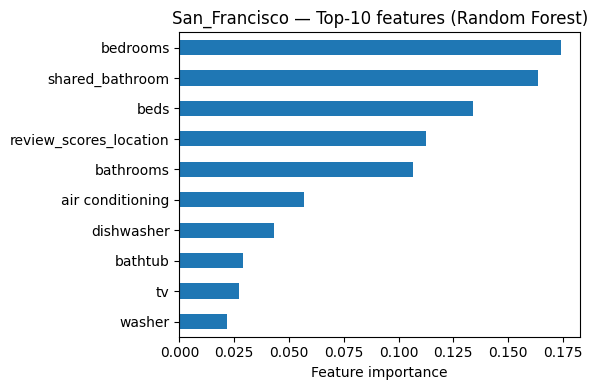

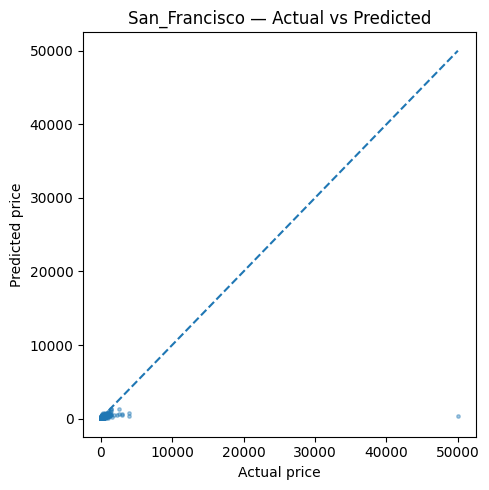

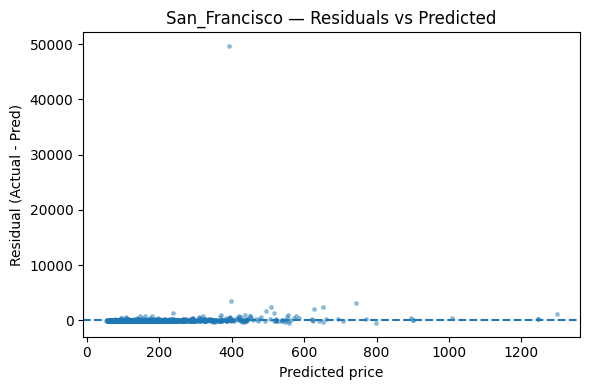

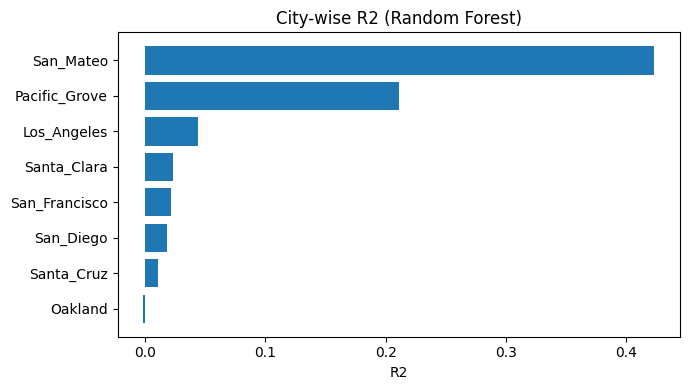

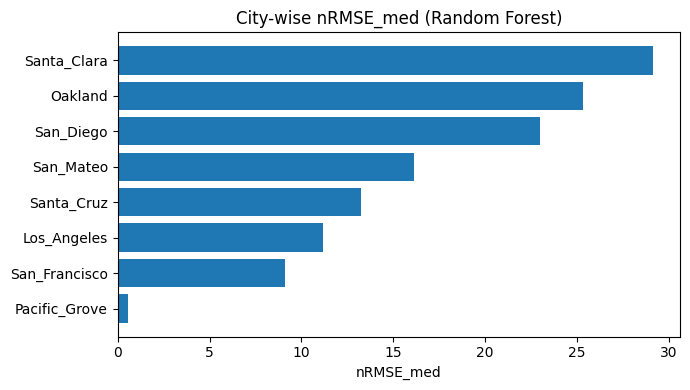

In [ ]:
plot_feat_importance("San_Francisco", top_k=10)
plot_actual_vs_pred("San_Francisco")
plot_residuals("San_Francisco")

plot_summary_bars(metric="R2")
plot_summary_bars(metric="nRMSE_med")

models: ['Los_Angeles', 'Oakland', 'Pacific_Grove', 'San_Diego', 'San_Francisco', 'San_Mateo', 'Santa_Clara', 'Santa_Cruz']
have varnames?: True
have canon?: False
COMMON_FEATS len: 29
demo city: Los_Angeles


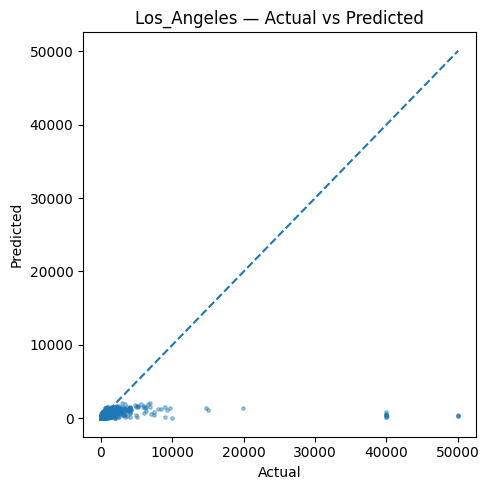

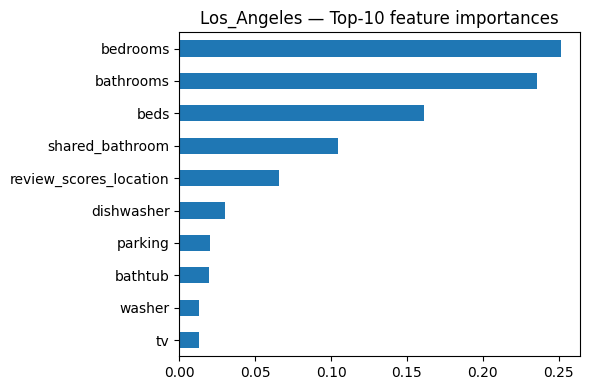

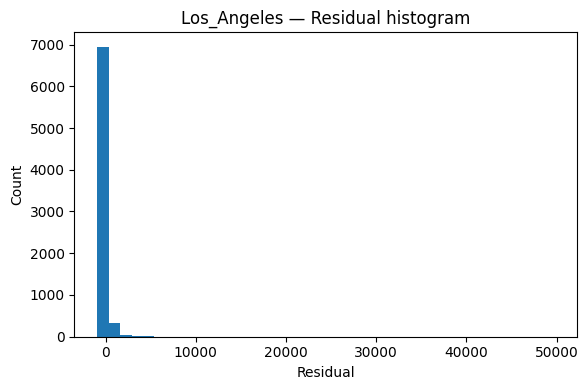

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print("models:", list(city_models.keys()))
print("have varnames?:", 'varnames' in globals())
print("have canon?:", 'canon' in globals())
print("COMMON_FEATS len:", len(COMMON_FEATS) if 'COMMON_FEATS' in globals() else "MISSING")

if 'COMMON_FEATS' not in globals() or not COMMON_FEATS:
    if city_models:
        any_key = list(city_models.keys())[0]
        city_guess = any_key
        tr_var, _ = varnames(city_guess)
        COMMON_FEATS = [c for c in globals()[tr_var].columns if c != 'price']
        print("COMMON_FEATS restored from training:", len(COMMON_FEATS))

def canon(name: str):
    return name.replace(" ", "_")

def get_tt(city):
    tr, te = varnames(city)
    tr_df = globals()[tr].reindex(columns=["price"] + COMMON_FEATS).dropna(subset=["price"])
    te_df = globals()[te].reindex(columns=["price"] + COMMON_FEATS).dropna(subset=["price"])
    return tr_df, te_df

def plot_pred_vs_actual(city):
    key = canon(city)
    _, te = get_tt(city)
    y_true = te["price"].to_numpy()
    X_te   = te[COMMON_FEATS].fillna(0)
    y_pred = np.expm1(city_models[key].predict(X_te))
    plt.figure(figsize=(5,5))
    plt.scatter(y_true, y_pred, s=6, alpha=0.4)
    a,b = y_true.min(), y_true.max()
    plt.plot([a,b],[a,b],'--')
    plt.xlabel("Actual"); plt.ylabel("Predicted")
    plt.title(f"{city} — Actual vs Predicted")
    plt.tight_layout(); plt.show()

def plot_top_importances(city, topk=10):
    key = canon(city)
    tr, _ = get_tt(city)
    X_cols = [c for c in tr.columns if c != "price"]
    imp = pd.Series(city_models[key].feature_importances_, index=X_cols)\
           .sort_values(ascending=False).head(topk)
    plt.figure(figsize=(6,4))
    imp[::-1].plot(kind="barh")
    plt.title(f"{city} — Top-{topk} feature importances")
    plt.tight_layout(); plt.show()

def plot_residual_hist(city, bins=30):
    key = canon(city)
    _, te = get_tt(city)
    y_true = te["price"].to_numpy()
    X_te   = te[COMMON_FEATS].fillna(0)
    y_pred = np.expm1(city_models[key].predict(X_te))
    resid  = y_true - y_pred
    plt.figure(figsize=(6,4))
    plt.hist(resid, bins=bins)
    plt.xlabel("Residual"); plt.ylabel("Count")
    plt.title(f"{city} — Residual histogram")
    plt.tight_layout(); plt.show()

city_demo = next(iter(city_models.keys())) if city_models else "San_Diego"
print("demo city:", city_demo)
plot_pred_vs_actual(city_demo)
plot_top_importances(city_demo, topk=10)
plot_residual_hist(city_demo, bins=40)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from google.colab import files

uploaded = files.upload()
fname = next(iter(uploaded))
housingdata = pd.read_csv(fname)

counties = ["Los Angeles", "Fresno", "San Diego", "Sacramento",
            "San Francisco", "Santa Clara", "Alameda"]

housingdata = housingdata[housingdata["County"].isin(counties)].copy()
housingdata = housingdata.drop(columns=['City', 'State'], errors='ignore')

for county in counties:
    county_data = housingdata[housingdata['County'] == county]

    X_train, X_test = train_test_split(
        county_data,
        test_size=0.2,
        random_state=42
    )

    train_var_name = f"{county.replace(' ', '_')}_train"
    test_var_name  = f"{county.replace(' ', '_')}_test"

    globals()[train_var_name] = X_train.reset_index(drop=True)
    globals()[test_var_name]  = X_test.reset_index(drop=True)

print(f"{'County':<15} {'Train Rows':<12} {'Test Rows':<12}")
print("-" * 40)

for county in counties:
    train_rows = globals()[f"{county.replace(' ', '_')}_train"].shape[0]
    test_rows  = globals()[f"{county.replace(' ', '_')}_test"].shape[0]
    print(f"{county:<15} {train_rows:<12} {test_rows:<12}")

Saving housingvars.csv to housingvars (5).csv
County          Train Rows   Test Rows   
----------------------------------------
Los Angeles     1260         315         
Fresno          816          205         
San Diego       807          202         
Sacramento      799          200         
San Francisco   679          170         
Santa Clara     637          160         
Alameda         546          137         


In [ ]:
sf_train = globals()['San_Francisco_train'].drop(columns=['Population'])
sf_test  = globals()['San_Francisco_test'].drop(columns=['Population'])

numeric_cols_train = sf_train.select_dtypes(include='number').columns
numeric_cols_test  = sf_test.select_dtypes(include='number').columns

sf_train[numeric_cols_train] = sf_train[numeric_cols_train].fillna(0)
sf_test[numeric_cols_test]   = sf_test[numeric_cols_test].fillna(0)

globals()['San_Francisco_train'] = sf_train
globals()['San_Francisco_test']  = sf_test

other_counties = ["Los_Angeles", "Fresno", "San_Diego", "Sacramento", "Santa_Clara", "Alameda"]

for county in other_counties:
    globals()[f"{county}_train"] = globals()[f"{county}_train"].dropna()
    globals()[f"{county}_test"]  = globals()[f"{county}_test"].dropna()

print(f"{'County':<15} {'Train Rows':<12} {'Test Rows':<12}")
print("-" * 40)

for county in counties:
    train_rows = globals()[f"{county.replace(' ', '_')}_train"].shape[0]
    test_rows  = globals()[f"{county.replace(' ', '_')}_test"].shape[0]
    print(f"{county:<15} {train_rows:<12} {test_rows:<12}")

County          Train Rows   Test Rows   
----------------------------------------
Los Angeles     1111         291         
Fresno          710          177         
San Diego       675          167         
Sacramento      676          167         
San Francisco   679          170         
Santa Clara     632          157         
Alameda         545          136         


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

model_to_use = RandomForestRegressor()

county_models = {}
county_metrics = {}

counties = ["Los_Angeles", "Fresno", "San_Diego", "Sacramento", "San_Francisco", "Santa_Clara", "Alameda"]

for county in counties:
    train_df = globals()[f"{county}_train"]
    test_df  = globals()[f"{county}_test"]

    X_train = train_df.drop(columns=['Price', 'County'], errors='ignore').select_dtypes(include=['float64', 'int64'])
    X_test  = test_df[X_train.columns]

    if X_train.shape[0] == 0 or X_train.shape[1] == 0:
        print(f"Skipping {county} because there are no valid features")
        continue

    y_train = train_df['Price']
    y_test  = test_df['Price']

    model_to_use.fit(X_train, y_train)
    y_pred = model_to_use.predict(X_test)

    county_models[county] = model_to_use
    metrics = {
        'RMSE': mean_squared_error(y_test, y_pred) ** 0.5,
        'R2': r2_score(y_test, y_pred)
    }
    county_metrics[county] = metrics

    print(f"{county}: RMSE = {metrics['RMSE']:.2f}, R2 = {metrics['R2']:.4f}")

Los_Angeles: RMSE = 1094803.96, R2 = 0.7186
Fresno: RMSE = 119845.31, R2 = 0.6917
San_Diego: RMSE = 475255.28, R2 = 0.7888
Sacramento: RMSE = 170865.64, R2 = 0.5995
San_Francisco: RMSE = 699547.92, R2 = 0.6687
Santa_Clara: RMSE = 453861.38, R2 = 0.5142
Alameda: RMSE = 314294.42, R2 = 0.4611


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

def winsor_clip(y, q=0.99):
    hi = np.quantile(y, q)
    return np.clip(y, 0, hi)

county_models = {}
county_metrics = {}

counties = ["Los_Angeles", "Fresno", "San_Diego",
            "Sacramento", "San_Francisco",
            "Santa_Clara", "Alameda"]

for county in counties:
    train_df = globals()[f"{county}_train"]
    test_df  = globals()[f"{county}_test"]

    X_train = train_df.drop(columns=['Price','County'], errors='ignore').select_dtypes(include=['float64','int64'])
    X_test  = test_df[X_train.columns]

    y_train_raw = train_df['Price'].values
    y_test_raw  = test_df['Price'].values

    y_train_clip = winsor_clip(y_train_raw, q=0.99)
    y_test_clip  = winsor_clip(y_test_raw,  q=0.99)

    y_train = np.log1p(y_train_clip)
    y_test  = np.log1p(y_test_clip)

    model = RandomForestRegressor(
        n_estimators=500,
        max_depth=None,
        min_samples_split=4,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    y_pred_log = model.predict(X_test)

    y_pred = np.expm1(y_pred_log)

    rmse = np.sqrt(mean_squared_error(y_test_clip, y_pred))
    r2   = r2_score(y_test_clip, y_pred)

    county_models[county] = model
    county_metrics[county] = {'RMSE': rmse, 'R2': r2}

    print(f"{county}: RMSE = {rmse:,.2f}, R2 = {r2:.4f}")

Los_Angeles: RMSE = 506,260.77, R2 = 0.8605
Fresno: RMSE = 112,349.69, R2 = 0.6371
San_Diego: RMSE = 451,178.82, R2 = 0.7787
Sacramento: RMSE = 153,905.60, R2 = 0.6645
San_Francisco: RMSE = 632,250.80, R2 = 0.6929
Santa_Clara: RMSE = 361,756.47, R2 = 0.6655
Alameda: RMSE = 233,286.67, R2 = 0.6940


In [ ]:
def add_more_feats_housing(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    eps = 1e-6

    if 'Bedrooms' in out.columns and 'Bathrooms' in out.columns:
        out['rooms_interact'] = out['Bedrooms'] * out['Bathrooms']
        out['rooms_total']    = out['Bedrooms'] + out['Bathrooms']
        out['bed_bath_ratio'] = out['Bedrooms'] / (out['Bathrooms'] + eps)

    if 'Sqft' in out.columns and 'Bedrooms' in out.columns:
        out['sqft_per_bedroom'] = out['Sqft'] / (out['Bedrooms'] + eps)

    if 'Sqft' in out.columns and 'Bathrooms' in out.columns:
        out['sqft_per_bath'] = out['Sqft'] / (out['Bathrooms'] + eps)

    if 'Sqft' in out.columns and 'Rooms' in out.columns:
        out['sqft_per_room'] = out['Sqft'] / (out['Rooms'] + eps)

    return out


def pick_best_rf_housing(X_tr, y_tr_log):
    base = dict(
        n_estimators=800,
        min_samples_split=4,
        min_samples_leaf=2,
        bootstrap=True,
        oob_score=True,
        random_state=42,
        n_jobs=-1
    )

    candidates = [
        dict(max_depth=14,  max_features='sqrt'),
        dict(max_depth=20,  max_features='sqrt'),
        dict(max_depth=None,max_features='sqrt'),
        dict(max_depth=18,  max_features=0.5),
        dict(max_depth=26,  max_features=0.5),
    ]

    best_model = None
    best_oob   = -np.inf

    for params in candidates:
        rf = RandomForestRegressor(**base, **params)
        rf.fit(X_tr, y_tr_log)
        oob_r2 = rf.oob_score_
        if oob_r2 > best_oob:
            best_oob   = oob_r2
            best_model = rf

    return best_model, best_oob

In [ ]:
county_models_v2  = {}
county_metrics_v2 = {}

drop_cols = ['Address', 'City', 'State', 'Zip', 'ZIP', 'County', 'ID']

for county in counties:

    train_df = globals()[f"{county}_train"].copy()
    test_df  = globals()[f"{county}_test"].copy()

    train_df = train_df.drop(columns=drop_cols, errors='ignore')
    test_df  = test_df.drop(columns=drop_cols, errors='ignore')

    X_train_raw = train_df.drop(columns=['Price'], errors='ignore')\
                          .select_dtypes(include=['float64','int64'])
    X_test_raw  = test_df[X_train_raw.columns]

    X_train = add_more_feats_housing(X_train_raw)
    X_test  = add_more_feats_housing(X_test_raw)

    y_train_raw = globals()[f"{county}_train"]['Price'].values
    y_test_raw  = globals()[f"{county}_test"]['Price'].values

    y_train_clip = winsor_clip(y_train_raw, q=0.99)
    y_test_clip  = winsor_clip(y_test_raw,  q=0.99)
    y_train_log  = np.log1p(y_train_clip)

    best_model, best_oob = pick_best_rf_housing(X_train, y_train_log)

    y_pred_log = best_model.predict(X_test)
    y_pred     = np.expm1(y_pred_log)

    rmse = np.sqrt(mean_squared_error(y_test_clip, y_pred))
    r2   = r2_score(y_test_clip, y_pred)

    county_models_v2[county] = best_model
    county_metrics_v2[county] = {'RMSE': rmse, 'R2': r2, 'OOB_R2': best_oob}

    fi = pd.Series(best_model.feature_importances_, index=X_train.columns)\
           .sort_values(ascending=False)
    top5 = ", ".join(fi.head(5).index.tolist())

    print(f"{county}: RMSE = {rmse:,.2f}, R2 = {r2:.4f}, OOB_R2 = {best_oob:.4f} | top: {top5}")

Los_Angeles: RMSE = 491,728.21, R2 = 0.8684, OOB_R2 = 0.8226 | top: Living Space, Baths, Beds, Latitude, Longitude
Fresno: RMSE = 106,451.42, R2 = 0.6742, OOB_R2 = 0.6840 | top: Living Space, Baths, Latitude, Beds, Longitude
San_Diego: RMSE = 439,784.70, R2 = 0.7898, OOB_R2 = 0.8282 | top: Living Space, Longitude, Baths, Latitude, Beds
Sacramento: RMSE = 140,509.45, R2 = 0.7204, OOB_R2 = 0.6129 | top: Living Space, Longitude, Latitude, Beds, Baths
San_Francisco: RMSE = 579,204.77, R2 = 0.7422, OOB_R2 = 0.7393 | top: Living Space, Baths, Latitude, Longitude, Beds
Santa_Clara: RMSE = 339,982.62, R2 = 0.7046, OOB_R2 = 0.6767 | top: Living Space, Beds, Longitude, Baths, Latitude
Alameda: RMSE = 200,461.89, R2 = 0.7741, OOB_R2 = 0.7918 | top: Living Space, Baths, Beds, Latitude, Longitude
